In [1]:
import plac
import random
import pandas as pd 
from pathlib import Path
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
import networkx as nx
%matplotlib inline  


C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
# Extract Relationships section

In [3]:
def extract_event_loc_relations(doc):
    # merge entities and noun chunks into one token
    spans = list(doc.ents) + list(doc.noun_chunks)
    for span in spans:
        span.merge()

    relations = []
    for location in filter(lambda w: w.ent_type_ == 'LOC', doc):
        if location.dep_ in ('attr', 'dobj'):
            subject = [w for w in location.head.lefts if w.dep_ == 'nsubj']
            if subject:
                subject = subject[0]
                relations.append((subject, location))
        elif location.dep_ == 'pobj' and location.head.dep_ == 'prep':
            relations.append((location.head.head, location))
    return relations

In [4]:
def extract_person_loc_relations(doc):
    # merge entities and noun chunks into one token
    spans = list(doc.ents) + list(doc.noun_chunks)
    for span in spans:
        span.merge()

    relations_person = []
    for person in filter(lambda w: w.ent_type_ == 'PERSON', doc):
        if person.dep_ in ('attr', 'dobj'):
            subject = [w for w in person.head.lefts if w.dep_ == 'nsubj']
            if subject:
                subject = subject[0]
                relations_person.append((subject, person))
        elif person.dep_ == 'pobj' and person.head.dep_ == 'prep':
            person.append((person.head.head, person))
    return relations_person

In [5]:
# new entity label
LABEL = 'RANK'

# training data
TRAIN_DATA = [
    ('Mandro training centre', {
        'entities': [(0, 22, 'LOC')]
    }),
    ('My name is Marcus BRODY. I am 15 years old', {
        'entities': [(11, 24, 'PERSON')]
    }),
    ('visited the camp one time', {
        'entities': [(0, 25, 'EVENT')]
    }),
    ('I went to a rally in Goma', {
        'entities': [(21, 25, 'LOC')]
    }),
    ('In late 2002', {
        'entities': [(8, 12, 'DATE')]
    }),
    ('there was a lot of fighting in Goma', {
        'entities': [(31, 35, 'LOC')]
    }), 
    ("I remember one of the commanders who spoke was Chief KOBONO", {
        'entities': [(47, 52, 'RANK')]
    }),
    ("The President, Ule MATOBO GOBO", {
        'entities': [(0, 13, 'RANK')]
    }),
     ('there was a lot of fighting in Goma', {
        'entities': [(19, 35, 'EVENT')]
    })
    
]

In [6]:
#add new entity
nlp = spacy.load('en')
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner)
# otherwise, get it, so we can add labels to it
else:
    ner = nlp.get_pipe('ner')
    ner.add_label(LABEL)   # add new entity label to entity recognizer

optimizer = nlp.begin_training()
for i in range(20):
    random.shuffle(TRAIN_DATA)
    for text, annotations in TRAIN_DATA:
        nlp.update([text], [annotations], sgd=optimizer)
nlp.to_disk('model')
        
# test the trained model
for text, _ in TRAIN_DATA:
        doc = nlp(text)
        if text != "":
            print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
        #print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])
        
#df = pd.DataFrame.from_dict(ent.text, ent.label_)
#df.drop_duplicates(keep=False, inplace=True)
#df.head()
#df.to_csv('WITNESS_OUT_NODES.csv',header=['label','node_type'],index_label='Id')

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


Entities [('The President', 'RANK')]
Entities [('visited the camp one time', 'EVENT')]
Entities [('Marcus BRODY.', 'PERSON')]
Entities [('Mandro training centre', 'LOC')]
Entities [('2002', 'DATE')]
Entities [('Goma', 'LOC')]
Entities [('Goma', 'LOC')]
Entities [('Goma', 'LOC')]
Entities [('Chief', 'RANK')]


In [7]:
#import text file
witness_file = open('witness_text_clean.txt','r')
#witness_file = open('witness2.txt','r')
text_witness = ""
text_witness = witness_file.read() 
if text_witness != "":
   text = text_witness

#load spacy model
nlp = spacy.load('model')
#nlp = spacy.load('en_core_web_lg')
#doc = nlp(text_witness)

#create relationships
doc = nlp(text_witness)
relations = extract_event_loc_relations(doc)
for r1, r2 in relations:
    print('RELATIONSHIP :'+'{:<10}\t{}\t{}'.format(r1.text,r2.ent_type_,r2.text))
    
#if relations !="":
    relation_df = pd.DataFrame.from_dict(relations)
    relation_df.columns =['event', 'location']
    relation_df['event'] = [token.text for token in relation_df['event'].values]
    relation_df['location'] = [token.text for token in relation_df['location'].values]
    relation_df['relation'] = 'took_place_at'
    relation_df.to_csv('WITNESS_STAT_OUTPUT_NODES.csv',index_label='Id')
#else:
#    print('NO RELATIONS FOUND')

        
# Print the results

displacy.render(doc, style='ent',jupyter=True)

RELATIONSHIP :fighting  	LOC	Goma
RELATIONSHIP :a rally   	LOC	Goma


In [8]:
events = list(set(relation_df['event'].values))
locations = list(set(relation_df['location'].values))
types = ['event'] * len(events) + ['location'] * len(locations)

entity_df = pd.DataFrame({'entity': events + locations, 'type': types})


In [9]:
entity_df

,entity,type
0,a rally,event
1,fighting,event
2,Goma,location


In [10]:
relation_df

,event,location,relation
0,fighting,Goma,took_place_at
1,a rally,Goma,took_place_at


In [11]:
event_ids =  [entity_df.index[entity_df['entity'] == entity_name].tolist()[0] for entity_name in relation_df['event']]
relation_df['event_id'] = event_ids
location_ids =  [entity_df.index[entity_df['entity'] == entity_name].tolist()[0] for entity_name in relation_df['location']]
relation_df['location_id'] = location_ids

In [12]:
G = nx.from_pandas_edgelist(df=relation_df, source='event_id', target='location_id', edge_attr='relation')
entity_ids = entity_df.index.values
G.add_nodes_from(entity_ids)
nx.set_node_attributes(G, {i:{'Name': row['entity']} for i,row in entity_df.iterrows()})

In [22]:
labels = {i:row['entity'] for i,row in entity_df.iterrows()}
edge_labels = {i:' took place at ' for i,row in entity_df.iterrows()}

In [21]:
labels

{0: 'a rally', 1: 'fighting', 2: 'Goma'}

In [23]:
edge_labels

{0: ' took place at ', 1: ' took place at ', 2: ' took place at '}

In [14]:
entity_df['entity'].values

array(['a rally', 'fighting', 'Goma'], dtype=object)

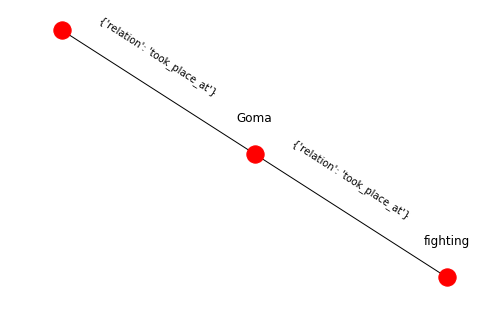

In [24]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
#bb = nx.edge_betweenness_centrality(G, normalized=False)
#nx.set_edge_attributes(G, ' took place at ', bb)
nx.draw(G, pos, font_size=16, with_labels=False)
for p in pos:
    pos[p][1] += 0.15

#nx.draw_networkx_edges(G, pos, style='solid', alpha=0.2,labels=' took place at ')
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)
plt.show()
#plt.imsave('abc.png')  # todo: this is not tested!